# Natural language engineering 2: Assignment

## Classification of Twitter posts regarding the Russo-Ukrainian War by emotion

A project by **Johannes Wittmann** and **Quirin Wittmann**.

In [ ]:
from pprint import pprint

### Data crawling

We created a separate python script to crawl our tweet data-set.<br> **You can find it here:** [LINK TO CRAWLING SCRIPT](https://github.com/JohannesWittmann9/bert_tweet_emotion_classification/blob/main/twitter.py)

### Model finetuning

Neccesary dependencys for finetuning with Huggingface.

In [ ]:
!pip install datasets transformers
!pip install accelerate

Finetuning imports:


In [ ]:
from datasets import load_dataset
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Load Twitter dataset for emotions: <br>
[https://huggingface.co/datasets/tweet_eval/viewer/emotion/train](https://huggingface.co/datasets/tweet_eval/viewer/emotion/train)

In [ ]:
emotion_dataset = load_dataset("tweet_eval", "emotion")
print(emotion_dataset["train"][0])

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry", 'label': 2}


Embedd tweets:

In [ ]:
#checkpoint = "bhadresh-savani/distilbert-base-uncased-emotion" 
#checkpoint = "bert-base-uncased"
#checkpoint = "bert-large-uncased" 
#checkpoint = "roberta-large" 
#checkpoint = "cardiffnlp/twitter-roberta-base-sentiment" 
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest"
#!pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Testing different parameters and models. A list of some performance values:

**checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest"** <br>
```
learning-rate = 2e-5
{'epoch': 9.0,
 'eval_accuracy': 0.8515130190007038,
 'eval_f1': 0.8272981315532062,
 'eval_loss': 0.6312467455863953,
 'eval_precision': 0.8276227955564548,
 'eval_recall': 0.8269873400810889,
 'eval_runtime': 4.5624,
 'eval_samples_per_second': 311.456,
 'eval_steps_per_second': 5.041}

 {'epoch': 3.0,
 'eval_accuracy': 0.848698099929627,
 'eval_f1': 0.8150505541911199,
 'eval_loss': 0.45493319630622864,
 'eval_precision': 0.8257694057902196,
 'eval_recall': 0.8067207620660877,
 'eval_runtime': 4.6065,
 'eval_samples_per_second': 308.476,
 'eval_steps_per_second': 4.993}

 learning-rate = 3e-5
 {'epoch': 9.0,
 'eval_accuracy': 0.8458831808585503,
 'eval_f1': 0.820937721661935,
 'eval_loss': 0.7216904163360596,
 'eval_precision': 0.8226266097306008,
 'eval_recall': 0.8193645672753254,
 'eval_runtime': 4.5575,
 'eval_samples_per_second': 311.797,
 'eval_steps_per_second': 5.047}

 learning-rate = 4e-5
 {'epoch': 9.0,
 'eval_accuracy': 0.8458831808585503,
 'eval_f1': 0.8160937096965186,
 'eval_loss': 0.8133470416069031,
 'eval_precision': 0.8181164501984326,
 'eval_recall': 0.8141543753847649,
 'eval_runtime': 4.0836,
 'eval_samples_per_second': 347.977,
 'eval_steps_per_second': 5.632}

```



Tokenisation function defining:

In [ ]:
def tokenize_example(example):
  return tokenizer(example["text"], truncation=True)

Tokenize dataset with function:

In [ ]:
emotion_dataset_tokenized = emotion_dataset.map(tokenize_example, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Defining the dataset padder:

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Classification Head:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Define the evaluation function.
Huggingface reccomends accuracy, recall, precision and F1 for text classification. <br>
[Metrics for Text Classification](https://huggingface.co/tasks/text-classification)

In [ ]:
def evaluate(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average="macro")
  recall = recall_score(labels, preds, average="macro")
  return {"precision": precision, "recall": recall, "accuracy": accuracy, "f1": f1}

Defining the trainingparameters:

In [ ]:
batch_size = 64
logging_steps = len(emotion_dataset_tokenized["train"])
model_name = f"{checkpoint}-finetuned-tweet_emotion"
training_args = TrainingArguments(output_dir = model_name, 
                                  num_train_epochs = 9, 
                                  learning_rate = 2e-5, 
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm = False, 
                                  logging_steps = logging_steps, 
                                  log_level="error")

Creating the trainer:

In [ ]:
print(len(emotion_dataset_tokenized["train"]))
print(len(emotion_dataset_tokenized["test"]))
print(len(emotion_dataset_tokenized["validation"]))
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = evaluate,
    train_dataset=emotion_dataset_tokenized["train"], 
    eval_dataset=emotion_dataset_tokenized["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

3257
1421
374


Training:

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Precision,Recall,Accuracy,F1
1,No log,0.519328,0.761515,0.723486,0.810160,0.738781
2,No log,0.534493,0.770164,0.729257,0.812834,0.741971
3,No log,0.505020,0.753276,0.760227,0.831551,0.755820
4,No log,0.543008,0.743627,0.755771,0.823529,0.748139
5,No log,0.578184,0.764762,0.766864,0.834225,0.765542
6,No log,0.581261,0.762799,0.775009,0.836898,0.768205
7,No log,0.650903,0.755713,0.768006,0.826203,0.757282
8,No log,0.634889,0.741622,0.754525,0.823529,0.746551
9,No log,0.642723,0.749034,0.757368,0.823529,0.750820


TrainOutput(global_step=459, training_loss=0.2905844894109988, metrics={'train_runtime': 253.4954, 'train_samples_per_second': 115.635, 'train_steps_per_second': 1.811, 'total_flos': 774926848285512.0, 'train_loss': 0.2905844894109988, 'epoch': 9.0})

Evaluate Model

In [ ]:
evaluation_result = trainer.evaluate(eval_dataset=emotion_dataset_tokenized["test"])
pprint(evaluation_result)
import os
if os.path.exists("trainer_evaluation_metrics.txt"):
  os.remove("trainer_evaluation_metrics.txt")
with open('trainer_evaluation_metrics.txt', 'w') as f:
    f.write(str(evaluation_result))

{'epoch': 9.0,
 'eval_accuracy': 0.8472906403940886,
 'eval_f1': 0.821333611697579,
 'eval_loss': 0.6099019646644592,
 'eval_precision': 0.8151631188862769,
 'eval_recall': 0.8287354665914795,
 'eval_runtime': 4.0218,
 'eval_samples_per_second': 353.322,
 'eval_steps_per_second': 5.719}


In [ ]:
trainer.save_model("./outputmodel")

### Classification

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

In [ ]:
import os
os.listdir("/content/outputmodel/")

In [ ]:
checkpoint = "/content/outputmodel/"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
emotion_pipe = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

print(model.config.id2label)

Test of the pipeline:

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
    "I love this so much",
    "I am looking forward to it",
    "We must stay optimistic",
    "Why did this happen?",
    "Why did you do this to me?",
    "Why didn't you clean this mess?",
    "I am sorry",
    "I am so excited",
]
#0: anger
#1: joy
#2: optimism
#3: sadness
pprint(emotion_pipe(raw_inputs))

In [ ]:
predictions = emotion_pipe(raw_inputs)

In [ ]:
predicted_labels = []
for prediction in predictions:
  predicted_labels.append(prediction['label'].lower())
pprint(predicted_labels)

### Initializing translator

In [ ]:
!pip install deep-translator
from deep_translator import GoogleTranslator

def translateText(sourceLanguage, text):
  return GoogleTranslator(source=sourceLanguage, target="en").translate(text)


Imports, label and event definitions

In [4]:
import pandas as pd
import random
import numpy as np
import datetime
from dateutil.parser import parse
from google.colab import files
import re
from datetime import datetime, timedelta


dates = ["2022-02-24", "2022-02-26", "2022-03-05", "2022-04-07", "2022-05-15", "2022-06-06"]
labelNames = ["Joy", "Anger", "Optimism", "Sadness"]

def computeEvent(timestamp):
  return parse(timestamp)

def labelToEmotion(label):
  if(label == "LABEL_0"):
    return "Anger"
  elif(label == "LABEL_1"):
    return "Joy"
  elif(label == "LABEL_2"):
    return "Optimism"
  elif(label == "LABEL_3"):
    return "Sadness"

# Crawled data-set description

In [ ]:
# Load tweets into session storage
try:
  tweets_df = pd.read_csv("./tweets.csv")
except:
  raise Exception("Please load tweets.csv into colab session storage. (Dateien -> In Sitzungsspeicher hochladen)")


In [ ]:
tweets_df

,id,created_at,text,lang,user_id,location,profile_location,utc_offset,user_lang,tweet_place_id
0,1501347033122283523,2022-03-09 00:00:01+00:00,Logged on to @indeed and this! ❤️🇺🇦👏🏼 #Ukraine...,en,578604624,"Tennessee, USA",NaN,NaN,NaN,NaN
1,1501347063853838336,2022-03-09 00:00:08+00:00,RT @MizzimaNews: #UKRAINE CONUNDRUM: Myanmar a...,en,1313788055384322048,NaN,NaN,NaN,NaN,NaN
2,1501347042060349441,2022-03-09 00:00:03+00:00,RT @JackPosobiec: Wait what...?,en,1492016541810016258,NaN,NaN,NaN,NaN,NaN
3,1501347035290632195,2022-03-09 00:00:01+00:00,THE WORLD NEWS:\nRussia:\nWatch the Russian po...,en,1457117391603867658,NaN,NaN,NaN,NaN,NaN
4,1501347065237889027,2022-03-09 00:00:08+00:00,#Russia is seeking to reap extra benefits from...,en,2579842441,Brazil,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
21387,1531788262020456450,2022-06-01 00:02:35+00:00,RT @EmineDzheppar: This is Rubizhne town. Once...,en,283551577,Munich 🇩🇪,NaN,NaN,NaN,NaN
21388,1531788056121966592,2022-06-01 00:01:46+00:00,Via #Glasgow\n.@FIFAWorldCup #SCOUKR 🇺🇦 \n.@u...,en,3079197865,"Denver, Colorado USA",NaN,NaN,NaN,NaN
21389,1531787632975519744,2022-06-01 00:00:05+00:00,RT @lopatonok: Once again our film “Revealing ...,en,1364399932304732161,Ciudad Autónoma de Buenos Aire,NaN,NaN,NaN,NaN
21390,1531787723522048002,2022-06-01 00:00:27+00:00,"Wer es anders sieht, verkennt die Lage. #Putin...",de,1214077734,NaN,NaN,NaN,NaN,NaN


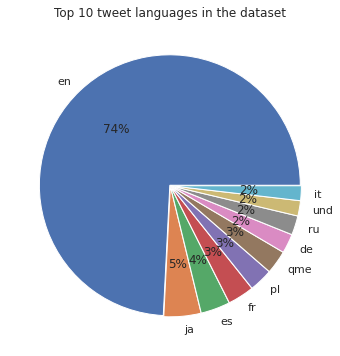

In [ ]:
counts = tweets_df["lang"].value_counts()[:10]

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.keys(), autopct = '%0.0f%%', explode = np.full(len(counts), 0.005))
plt.title("Top 10 tweet languages in the dataset")
plt.savefig("total_languages_pie.png", dpi=300)
plt.show()

# Preprocessing and translating

In [ ]:
rows = len(tweets_df.index)

all_Scores = np.array([])
classification_results_list = []

for i in range(rows):
  id = tweets_df.iloc[i]["id"]
  text = tweets_df.iloc[i]["text"]
  pattern = re.compile("https:\/\/t\.co\/\S{10}", re.IGNORECASE)
  text = pattern.sub("", text)
  event = computeEvent(tweets_df.iloc[i]["created_at"])
  lang = tweets_df.iloc[i]["lang"]
  translatedText = translateText('auto', text)
  try:
    label = emotion_pipe(translatedText)
  except ValueError as e:
    pprint(translatedText)
    pprint(type(translatedText))
    if translatedText is None:
      continue
    else:
      raise(e)
  pprint("At:"+str((i/rows)*100)+"%")
  computedScore = label[0]["score"]
  all_Scores = np.append(all_Scores, computedScore)
  computedLabel = labelToEmotion(label[0]["label"])
  classification_results_list.append({"id": id,"label": computedLabel, "event": event, "text": translatedText})
 
#pprint(classification_results_list)

df_results = pd.DataFrame(classification_results_list)
df_results.to_csv("tweets_processed.csv")

mean_score = np.mean(all_Scores)
median_score = np.median(all_Scores)
pprint("Prediction Score Mean: "+str(mean_score))
pprint("Prediction Score Median: "+str(median_score))

if os.path.exists("prediction_score_evaluation.txt"):
  os.remove("prediction_score_evaluation.txt")
with open('prediction_score_evaluation.txt', 'w') as f:
    f.write("Mean: "+str(mean_score)+"\n")
    f.write("Median: "+str(median_score)+"\n")


## Downloading generated evaluation files

In [ ]:
files.download("trainer_evaluation_metrics.txt")
files.download("prediction_score_evaluation.txt")
files.download("tweets_processed.csv")

# Starting point for analysis

In [1]:
# Just incase your starting at this point
import pandas as pd
from pprint import pprint

df_results = pd.read_csv("./tweets_processed.csv",
                 lineterminator='\n')
pprint(df_results.head(100))
print(len(df_results.index))

    Unnamed: 0                   id    label                      event  \
0            0  1501347033122283523      Joy  2022-03-09 00:00:01+00:00   
1            1  1501347063853838336  Sadness  2022-03-09 00:00:08+00:00   
2            2  1501347042060349441  Sadness  2022-03-09 00:00:03+00:00   
3            3  1501347035290632195  Sadness  2022-03-09 00:00:01+00:00   
4            4  1501347065237889027      Joy  2022-03-09 00:00:08+00:00   
..         ...                  ...      ...                        ...   
95          95  1501347064810201093    Anger  2022-03-09 00:00:08+00:00   
96          96  1501347049291206656    Anger  2022-03-09 00:00:04+00:00   
97          97  1501347073181978627  Sadness  2022-03-09 00:00:10+00:00   
98          98  1501347058430713870    Anger  2022-03-09 00:00:07+00:00   
99          99  1501347073307947013  Sadness  2022-03-09 00:00:10+00:00   

                                                 text  
0      Logged on to @indeed and this! ❤️🇺🇦👏

# Converting and calculating date information

In [2]:
from dateutil.parser import parse
import pytz

utc=pytz.UTC
  
def getDataframeAfterEvent(df, events):
    df_after_event = df.loc[df['event'].isin(events)]
    return df_after_event

# convert a date to an event date if its in range
# e.g. If we look at Event 25.02.2022 and want tweets that happened
# up to 3 days after, those dates will be converted to the event date (25.02.2022)
def convertToEventDate(dt, daysRange):
    # datetime daysRange days before the dt
    date_range =  dt - timedelta(daysRange)
    date_of_tweet = dt.replace(tzinfo=utc)
    end_of_range = date_range.replace(tzinfo=utc)
    # Test if event matches a date so 26.02 will stay 26.02 and not be labeled as
    # 24.02 because of a to high date range
    for date in dates:
      date_string = dt.strftime("%Y-%m-%d")
      if (date_string == date):
        return dt

    # Searches the closest event-date for a tweet 
    # so 27.02 will be 26.02 and not 24.02 
    closest_date = dates[0]
    for date in dates:
      parse_date = parse(date).replace(tzinfo=utc)
      parse_closest = parse(closest_date).replace(tzinfo=utc)
      dt_ = dt.replace(tzinfo=utc)
      difference_to_closest = abs((parse_closest - dt_).total_seconds())
      difference_to_current = abs((parse_date - dt_).total_seconds())
      if(difference_to_closest > difference_to_current):
        closest_date = date

    for date in dates:
      date_parsed = parse(date)
      event = date_parsed.replace(tzinfo=utc)
      if event <= date_of_tweet and event >= end_of_range and date == closest_date:
        return date_parsed

    return dt

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

def dateToString(date):
  datetime_string = date.to_pydatetime().strftime("%Y-%m-%d")
  return datetime_string

# General event emotion overview


# Tweet timestamps are converted
df_polarizing_events = df_results.copy()
df_all_dates = df_results.copy()

dateList = []
for idx, row in df_polarizing_events.iterrows():
    date = df_polarizing_events.loc[idx,'event']
    datetime_obj = datetime.strptime(date[:18], '%Y-%m-%d %H:%M:%S')
    datetime_string = convertToEventDate(datetime_obj, 4).strftime("%Y-%m-%d")
    dateList.append(datetime_string)
    

# Did not find a proper way to do it
# New polished event list is set
del df_polarizing_events['event']
df_polarizing_events['event'] = dateList


dateList = []
for idx, row in df_all_dates.iterrows():
    date = df_all_dates.loc[idx,'event']
    datetime_string = date[:10]
    dateList.append(datetime_string)

del df_all_dates['event']
df_all_dates['event'] = dateList

# Lineplot to see the emotions of the tweets over time and in contrast to the selected events

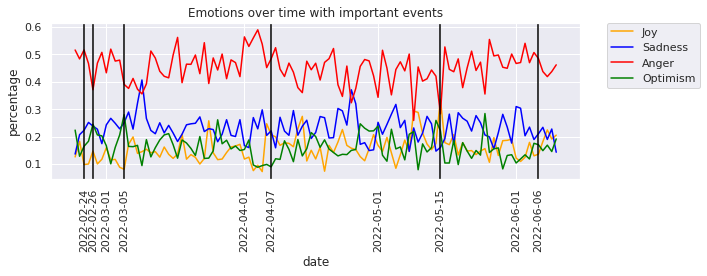

In [6]:
# Every date included

df_t = df_all_dates.copy()

dictionary = {}

for index, row in df_t.iterrows():
  key = row['label'] + "_" + row['event']
  if(key in dictionary):
    dictionary[key] = dictionary[key] + 1
  else:
    dictionary[key] = 1
#pprint(dictionary)

df_all_clean = pd.DataFrame(columns=["label", "date", "count"])

for k,v in dictionary.items():
  entry = pd.DataFrame.from_dict({
     "label": [k.split("_")[0]],
     "date":  [k.split("_")[1]],
     "count": [v]
     }) 
  df_all_clean = pd.concat([df_all_clean, entry], ignore_index=True)

df_all_clean["date"] = pd.to_datetime(df_all_clean["date"])
df_all_clean.sort_values(by='date', inplace=True)

date_count = {}

for index, row in df_all_clean.iterrows():
  curr_date = row["date"]
  if curr_date in date_count.keys():
    date_count[curr_date] = date_count[curr_date] + row["count"]
  else:
    date_count[curr_date] = row["count"]

for index, row in df_all_clean.iterrows():
  df_all_clean.at[index,"count"] = row["count"]/date_count[row["date"]]



sns.set(rc={"figure.figsize":(10, 4)})
ax = sns.lineplot(data=df_all_clean, x="date", y="count", hue="label", palette=["orange","blue","red","green"])
ax.set(title='Emotions over time with important events')
ax.set(ylabel="percentage")
ax.tick_params(axis='x', labelrotation=70)

event_df = pd.DataFrame(dates, columns=["date"])
month_dates = ["2022-03-01","2022-04-01","2022-05-01","2022-06-01"]
month_df = pd.DataFrame(month_dates, columns=["date"])
event_df = pd.concat([event_df, month_df], ignore_index=True)
event_df["date"] = pd.to_datetime(event_df["date"])
event_df.sort_values(by='date', inplace=True)
event_ticks = event_df["date"].apply(lambda x: x.to_pydatetime().strftime("%Y-%m-%d"))
plt.xticks(ticks = event_df["date"], labels = event_ticks, rotation = 'vertical')

for ev in dates:
  date_obj = datetime.strptime(ev[:18], '%Y-%m-%d')
  plt.axvline(date_obj, 0, 1, color = "black")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("percentage_per_day.png", dpi=300)

Because of the missing tweets at the begin of February and at the mid of June, we have a high amount on crawled tweets for a few days of these two months. In the next analysis steps we therefore focus on relative emotion fractions than on absolute count values.

In [ ]:
sns.set(rc={"figure.figsize":(10, 4)})
ax = sns.lineplot(data=df_all_clean[["date","count"]], x="date", y="count")
ax.tick_params(axis='x', labelrotation=70)
plt.show()

# Barchart to display the fractions of emotions on our selected events

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


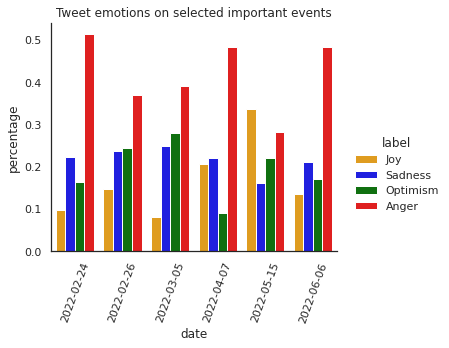

In [8]:
# Dates of events only with date-range tweet collection
with sns.axes_style('white'):
    new_df = df_all_clean.loc[df_all_clean["date"].isin(dates)]
    g = sns.factorplot(x="date", y="count", hue='label', data=new_df, kind='bar', order=dates, palette = ["orange","blue","green","red"])
    g.set(title='Tweet emotions on selected important events')
    g.set_xticklabels(rotation=70)
    dff = new_df["date"].apply(lambda x: x.to_pydatetime().strftime("%Y-%m-%d")).unique()
    g.set_xticklabels(dff)
    g.set(ylabel="percentage")
    g.tight_layout()
plt.savefig("bar_chart_important_events.png", dpi=300)

# Data-set description: Fractions of emotions

Anger       9772
Sadness     4817
Optimism    3503
Joy         3244
Name: label, dtype: int64


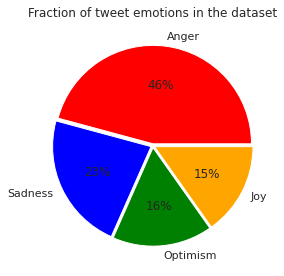

In [ ]:
counts = df_all_dates["label"].value_counts()
plt.pie(counts, labels=counts.keys(), colors = ["red", "blue", "green", "orange"], autopct = '%0.0f%%', explode = [0.02,0.02,0.02,0.02])
plt.title("Fraction of tweet emotions in the dataset")
plt.tight_layout()
plt.savefig("total_emotions_pie.png", dpi=300)
plt.show()

# Analysing tweets for mentioned hashtags

In [ ]:
mention_df = df_all_dates.copy()
mentions_putin = []
mentions_selenskyj = []
mention_df["text"] = mention_df["text"].astype("string").fillna('') #Empty texts as strings

russia_hash = ["#russia", "#putin"]
ukraine_hash = ["#ukraine", "#kyiv"]

russia_patterns = []
ukraine_patterns = []

for hash in russia_hash:
  pattern = re.compile("\\B"+hash+"\\b", re.IGNORECASE)
  russia_patterns.append(pattern)

for hash in ukraine_hash:
  pattern = re.compile("\\B"+hash+"\\b", re.IGNORECASE)
  ukraine_patterns.append(pattern)

for idx, row in mention_df.iterrows():
  text = row["text"]
  
  has_putin_hash = False
  for pattern in russia_patterns:
    if pattern.search(text) is not None:
      has_putin_hash = True

  has_selenskyj_mention = False
  for pattern in ukraine_patterns:
    if pattern.search(text) is not None:
      has_selenskyj_mention = True
  
  if has_putin_hash:
    mentions_putin.append("yes")
  else:
    mentions_putin.append("no")
  if has_selenskyj_mention:
    mentions_selenskyj.append("yes")
  else:
    mentions_selenskyj.append("no")

mention_df["putin"] = mentions_putin
mention_df["selenskyj"] = mentions_selenskyj
mention_df.drop(mention_df.columns[[0]], axis=1, inplace=True)

In [ ]:
contains_putin_df = mention_df.copy()
contains_putin_df = contains_putin_df.loc[contains_putin_df['putin'] == "yes"]

contains_selenskyj_df = mention_df.copy()
contains_selenskyj_df = contains_selenskyj_df.loc[contains_selenskyj_df['selenskyj'] == "yes"]

## Creating pie charts for emotion fractions of hashtag mentions

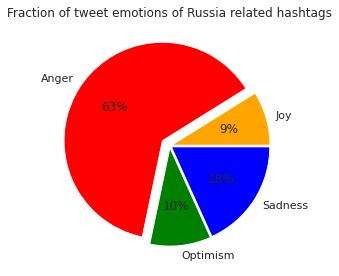

In [ ]:
df_t_p = contains_putin_df

dictionary = {}

for index, row in df_t_p.iterrows():
  key = row['label'] + "_" + row['event']
  if(key in dictionary):
    dictionary[key] = dictionary[key] + 1
  else:
    dictionary[key] = 1
#pprint(dictionary)

df_all_clean_putin = pd.DataFrame(columns=["label", "date", "count"])

for k,v in dictionary.items():
  entry = pd.DataFrame.from_dict({
     "label": [k.split("_")[0]],
     "date":  [k.split("_")[1]],
     "count": [v]
     }) 
  df_all_clean_putin = pd.concat([df_all_clean_putin, entry], ignore_index=True)

df_all_clean_putin["date"] = pd.to_datetime(df_all_clean_putin["date"])
df_all_clean_putin.sort_values(by='date', inplace=True)

df_percentage_putin = pd.DataFrame(columns=["label", "date", "count"])
date_count = {}

for index, row in df_all_clean_putin.iterrows():
  curr_date = row["date"]
  if curr_date in date_count.keys():
    date_count[curr_date] = date_count[curr_date] + row["count"]
  else:
    date_count[curr_date] = row["count"]

for index, row in df_all_clean_putin.iterrows():
  df_all_clean_putin.at[index,"count"] = row["count"]/date_count[row["date"]]
  
means = {} 
medians = {}

for label in labelNames:
  labelDf = df_all_clean_putin.loc[df_all_clean_putin["label"]==label]
  labelArr = labelDf["count"]
  mean = np.mean(labelArr)
  means[label] = mean
  median = np.median(labelArr)
  medians[label] = median

#pprint(means)
#pprint(medians)
d = pd.DataFrame(columns=["label", "percentage"])
for item in means.items():
  entry = pd.DataFrame.from_dict({
     "label": [item[0]],
     "percentage": [item[1]]
     }) 
  d = pd.concat([d, entry], ignore_index=True)
#pprint(d)
plt.pie(d["percentage"], labels=d["label"], colors = ["orange", "red", "green", "blue"], autopct = '%0.0f%%', explode = [0.02,0.09,0.02,0.02])
plt.title("Fraction of tweet emotions of Russia related hashtags")
plt.tight_layout()
plt.savefig("russia_emotion_pie.png", dpi=300)
plt.show()

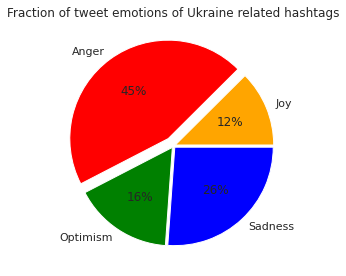

In [ ]:
df_t_s = contains_selenskyj_df

dictionary = {}

for index, row in df_t_s.iterrows():
  key = row['label'] + "_" + row['event']
  if(key in dictionary):
    dictionary[key] = dictionary[key] + 1
  else:
    dictionary[key] = 1
#pprint(dictionary)


df_all_clean_selenskyj = pd.DataFrame(columns=["label", "date", "count"])

for k,v in dictionary.items():
  entry = pd.DataFrame.from_dict({
     "label": [k.split("_")[0]],
     "date":  [k.split("_")[1]],
     "count": [v]
     }) 
  df_all_clean_selenskyj = pd.concat([df_all_clean_selenskyj, entry], ignore_index=True)

df_all_clean_selenskyj["date"] = pd.to_datetime(df_all_clean_selenskyj["date"])
df_all_clean_selenskyj.sort_values(by='date', inplace=True)

df_percentage_selenskyj = pd.DataFrame(columns=["label", "date", "count"])
date_count = {}

for index, row in df_all_clean_selenskyj.iterrows():
  curr_date = row["date"]
  if curr_date in date_count.keys():
    date_count[curr_date] = date_count[curr_date] + row["count"]
  else:
    date_count[curr_date] = row["count"]

for index, row in df_all_clean_selenskyj.iterrows():
  df_all_clean_selenskyj.at[index,"count"] = row["count"]/date_count[row["date"]]

means = {} 
medians = {}

for label in labelNames:
  labelDf = df_all_clean_selenskyj.loc[df_all_clean_selenskyj["label"]==label]
  labelArr = labelDf["count"]
  mean = np.mean(labelArr)
  means[label] = mean
  median = np.median(labelArr)
  medians[label] = median

#pprint(means)
#pprint(medians)
d = pd.DataFrame(columns=["label", "percentage"])
for item in means.items():
  entry = pd.DataFrame.from_dict({
     "label": [item[0]],
     "percentage": [item[1]]
     }) 
  d = pd.concat([d, entry], ignore_index=True)
#pprint(d)
plt.pie(d["percentage"], labels=d["label"], colors = ["orange", "red", "green", "blue"], autopct = '%0.0f%%', explode = [0.02,0.09,0.02,0.02])
plt.title("Fraction of tweet emotions of Ukraine related hashtags")
plt.tight_layout()
plt.savefig("ukraine_emotion_pie.png", dpi=300)
plt.show()


## Creating a plot for russian related tweets

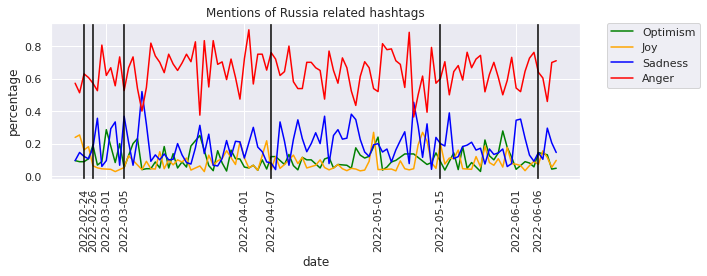

In [ ]:
sns.set(rc={"figure.figsize":(10, 4)})
fig, ax = plt.subplots()
sns.lineplot(data=df_all_clean_putin, x="date", y="count", hue="label", palette=["green","orange","blue","red"]).set(title='Mentions of Russia related hashtags')
ax.tick_params(axis='x', labelrotation=70)
ax.set(ylabel="percentage")
#ax.legend()

event_df = pd.DataFrame(dates, columns=["date"])
month_dates = ["2022-03-01","2022-04-01","2022-05-01","2022-06-01"]
month_df = pd.DataFrame(month_dates, columns=["date"])
event_df = pd.concat([event_df, month_df], ignore_index=True)
event_df["date"] = pd.to_datetime(event_df["date"])
event_df.sort_values(by='date', inplace=True)
event_ticks = event_df["date"].apply(lambda x: x.to_pydatetime().strftime("%Y-%m-%d"))
plt.xticks(ticks = event_df["date"], labels = event_ticks, rotation = 'vertical')

#date_ticks = df_all_clean["date"].apply(lambda x: x.to_pydatetime().strftime("%Y-%m-%d"))
#plt.xticks(ticks = df_all_clean["date"], labels = date_ticks, rotation = 'vertical')
for ev in dates:
  date_obj = datetime.strptime(ev[:18], '%Y-%m-%d')
  plt.axvline(date_obj, 0, 1, color = "black")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("amount_mentions_putin_per_day.png", dpi=300)


## Creating a plot for ukrainian related tweets

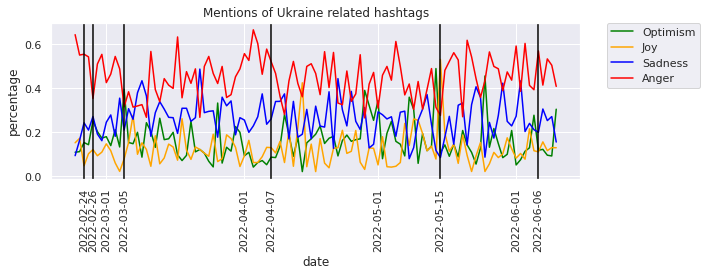

In [ ]:
sns.set(rc={"figure.figsize":(10, 4)})
fig, ax = plt.subplots()
sns.lineplot(data=df_all_clean_selenskyj, x="date", y="count", hue="label", palette=["green","orange","blue","red"]).set(title='Mentions of Ukraine related hashtags')
ax.tick_params(axis='x', labelrotation=70)
ax.set(ylabel="percentage")

event_df = pd.DataFrame(dates, columns=["date"])
month_dates = ["2022-03-01","2022-04-01","2022-05-01","2022-06-01"]
month_df = pd.DataFrame(month_dates, columns=["date"])
event_df = pd.concat([event_df, month_df], ignore_index=True)
event_df["date"] = pd.to_datetime(event_df["date"])
event_df.sort_values(by='date', inplace=True)
event_ticks = event_df["date"].apply(lambda x: x.to_pydatetime().strftime("%Y-%m-%d"))
plt.xticks(ticks = event_df["date"], labels = event_ticks, rotation = 'vertical')

for ev in dates:
  date_obj = datetime.strptime(ev[:18], '%Y-%m-%d')
  plt.axvline(date_obj, 0, 1, color = "black")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("amount_mentions_selenskyj_per_day.png", dpi=300)


# Plot-Download

In [ ]:
from google.colab import files
files.download("percentage_per_day.png")
files.download("amount_mentions_putin_per_day.png")
files.download("amount_mentions_selenskyj_per_day.png")
files.download("russia_emotion_pie.png")
files.download("ukraine_emotion_pie.png")
files.download("total_emotions_pie.png")
files.download("total_languages_pie.png")
files.download("bar_chart_important_events.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>